In [1]:
import os
import gc
import random
import joblib
import numpy as np
import pandas as pd
import datatable as dt
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

# Load Data

In [3]:
%%time
data_types_dict = {'row_id'            : 'int64',
                   'content_type_id'   : 'bool',
                   'timestamp'         : 'int64',
                   'user_id'           : 'int32', 
                   'content_id'        : 'int16', 
                   'answered_correctly': 'int8'}
train = dt.fread('../input/riiid-test-answer-prediction/train.csv', columns=set(data_types_dict.keys())).to_pandas()
train.content_type_id = (train.content_type_id * 1).astype("int8")

print(train.shape)
train.head(2)

(101230332, 6)
CPU times: user 1min 3s, sys: 11.5 s, total: 1min 15s
Wall time: 2min 53s


,row_id,timestamp,user_id,content_id,content_type_id,answered_correctly
0,0,0,115,5692,0,1
1,1,56943,115,5716,0,1


In [4]:
%%time
train_time_max = train.groupby(["user_id","timestamp"], as_index=False).row_id.max()
train_time_max["lagtime1"] = (train_time_max[["user_id","timestamp"]].groupby(["user_id"]).timestamp.shift(1) / (1000*3600)).astype("float32")
train_time_max["lagtime2"] = (train_time_max[["user_id","timestamp"]].groupby(["user_id"]).timestamp.shift(2) / (1000*3600)).astype("float32")
train_time_max["lagtime3"] = (train_time_max[["user_id","timestamp"]].groupby(["user_id"]).timestamp.shift(3) / (1000*3600)).astype("float32")
train_time_max.fillna(0, inplace=True)
train_time_max["lagtime_mean"] = (train_time_max.lagtime1 + train_time_max.lagtime2 + train_time_max.lagtime3) / 3
train_time_max = train_time_max[["row_id", "lagtime_mean"]]

print(train_time_max.shape)
train_time_max.head()

(78442619, 2)
CPU times: user 1min 28s, sys: 19.7 s, total: 1min 48s
Wall time: 1min 49s


,row_id,lagtime_mean
0,0,0.000000
1,1,0.000000
2,2,0.005273
3,3,0.016232
4,4,0.028377


In [5]:
%%time
train = train.merge(train_time_max, on="row_id", how="left")
del train_time_max
gc.collect()

train.lagtime_mean.fillna(method='bfill', inplace=True)
train.timestamp    = (train.timestamp / (1000*3600)).astype("float32")
train.lagtime_mean = np.log((train.timestamp - train.lagtime_mean) + 1).astype("float32")

train.drop(["row_id",'timestamp'], axis=1, inplace=True)
train.drop(train.loc[train.content_type_id==1].index, inplace=True)
train.drop(['content_type_id'], axis=1, inplace=True)
train.reset_index(drop=True, inplace=True)
gc.collect()

print(train.shape)
train.head()

(99271300, 4)
CPU times: user 57.3 s, sys: 15 s, total: 1min 12s
Wall time: 1min 12s


,user_id,content_id,answered_correctly,lagtime_mean
0,115,5692,1,0.000000
1,115,5716,1,0.015694
2,115,128,1,0.027232
3,115,7860,1,0.020002
4,115,7922,1,0.009897


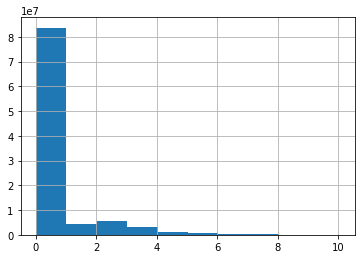

In [6]:
train.lagtime_mean.hist()

In [7]:
n_skill = train.content_id.nunique()
print("number skills", n_skill)

number skills 13523


In [8]:
%%time
group = train[['user_id', 'content_id', 'answered_correctly']].groupby('user_id').apply(lambda r: (r['content_id'].values, r['answered_correctly'].values))
lags  = train[['user_id', 'lagtime_mean']].groupby('user_id').apply(lambda r: (r['lagtime_mean'].values))
del train
gc.collect()

CPU times: user 44.4 s, sys: 3.44 s, total: 47.8 s
Wall time: 48.2 s


0

In [9]:
group

user_id
115           ([5692, 5716, 128, 7860, 7922, 156, 51, 50, 78...
124           ([7900, 7876, 175, 1278, 2064, 2063, 2065, 336...
2746          ([5273, 758, 5976, 236, 404, 382, 405, 873, 53...
5382          ([5000, 3944, 217, 5844, 5965, 4990, 5235, 605...
8623          ([3915, 4750, 6456, 3968, 6104, 5738, 6435, 54...
                                    ...                        
2147470770    ([7900, 7876, 175, 1278, 2064, 2065, 2063, 336...
2147470777    ([7900, 7876, 175, 1278, 2065, 2064, 2063, 336...
2147481750    ([4137, 1270, 9261, 8201, 367, 378, 214, 6071,...
2147482216    ([3748, 4765, 5474, 9261, 4665, 5987, 6666, 56...
2147482888    ([6147, 4792, 5738, 6102, 4748, 7956, 6435, 92...
Length: 393656, dtype: object

In [10]:
lags

user_id
115           [0.0, 0.015693728, 0.02723195, 0.020001857, 0....
124           [0.0, 0.009037659, 0.014096217, 0.014360532, 0...
2746          [0.0, 0.0059798616, 0.011563892, 0.013437186, ...
5382          [0.0, 0.011002586, 0.032497533, 0.026422245, 0...
8623          [0.0, 0.010711554, 0.016511815, 0.021797255, 0...
                                    ...                        
2147470770    [0.0, 0.006975939, 0.012366405, 0.0124929715, ...
2147470777    [0.0, 0.007416573, 1.838904, 1.5109953, 1.0289...
2147481750    [0.0, 0.0063605253, 0.007163672, 0.010623215, ...
2147482216    [0.0, 0.008451647, 0.011213261, 0.00993663, 0....
2147482888    [0.0, 0.005904731, 0.010321925, 0.012731698, 0...
Length: 393656, dtype: object

# Data Loaders

In [11]:
MAX_SEQ    = 100
ACCEPTED_USER_CONTENT_SIZE = 4
EMBED_SIZE = 128
BATCH_SIZE = 64*2
DROPOUT    = 0.1

In [12]:
class SAKTDataset(Dataset):
    def __init__(self, group, n_skill, max_seq=100):
        super(SAKTDataset, self).__init__()
        self.samples, self.n_skill, self.max_seq = {}, n_skill, max_seq
        
        self.user_ids = []
        for i, user_id in enumerate(group.index):
            content_id, answered_correctly = group[user_id]
            lagtime = lags[user_id]
            if len(content_id) >= ACCEPTED_USER_CONTENT_SIZE:
                if len(content_id) > self.max_seq:
                    total_questions = len(content_id)
                    last_pos = total_questions // self.max_seq
                    for seq in range(last_pos):
                        index = f"{user_id}_{seq}"
                        self.user_ids.append(index)
                        start = seq * self.max_seq
                        end   = (seq + 1) * self.max_seq
                        self.samples[index] = (content_id[start:end], answered_correctly[start:end], lagtime[start:end])
                    if len(content_id[end:]) >= ACCEPTED_USER_CONTENT_SIZE:
                        index = f"{user_id}_{last_pos + 1}"
                        self.user_ids.append(index)
                        self.samples[index] = (content_id[end:], answered_correctly[end:], lagtime[end:])
                else:
                    index = f'{user_id}'
                    self.user_ids.append(index)
                    self.samples[index] = (content_id, answered_correctly, lagtime)
                
                
    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, index):
        user_id = self.user_ids[index]
        content_id, answered_correctly, lagtime = self.samples[user_id]
        seq_len = len(content_id)
        
        content_id_seq         = np.zeros(self.max_seq, dtype=int)
        answered_correctly_seq = np.zeros(self.max_seq, dtype=int)
        lagtime_seq            = np.zeros(self.max_seq, dtype=float)
        if seq_len >= self.max_seq:
            content_id_seq[:]         = content_id[-self.max_seq:]
            answered_correctly_seq[:] = answered_correctly[-self.max_seq:]
            lagtime_seq[:]            = lagtime[-self.max_seq:]
        else:
            content_id_seq[-seq_len:]         = content_id
            answered_correctly_seq[-seq_len:] = answered_correctly
            lagtime_seq[-seq_len:]            = lagtime
            
        target_id = content_id_seq[1:]
        label     = answered_correctly_seq[1:]
        
        x1  = content_id_seq[:-1].copy()
        x1 += (answered_correctly_seq[:-1] == 1) * self.n_skill
        x2  = lagtime_seq[:-1].copy()
        
        return x1, x2, target_id, label

In [13]:
TEST_SIZE  = 0.2
train, val = train_test_split(group, test_size = TEST_SIZE)

In [14]:
train_dataset    = SAKTDataset(train, n_skill, max_seq=MAX_SEQ)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
del train

val_dataset      = SAKTDataset(val, n_skill, max_seq=MAX_SEQ)
val_dataloader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
del val
gc.collect()

0

In [15]:
sample_batch = next(iter(train_dataloader))
sample_batch[0].shape, sample_batch[1].shape, sample_batch[2].shape, sample_batch[3].shape

(torch.Size([128, 99]),
 torch.Size([128, 99]),
 torch.Size([128, 99]),
 torch.Size([128, 99]))

# Define model

In [16]:
def future_mask(seq_length):
    future_mask = (np.triu(np.ones([seq_length, seq_length]), k = 1)).astype('bool')
    return torch.from_numpy(future_mask)

future_mask(5)

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])

In [17]:
class FFN(nn.Module):
    def __init__(self, state_size=200, forward_expansion=1, bn_size=(MAX_SEQ-1), dropout=0.2):
        super(FFN, self).__init__()
        self.state_size = state_size
        
        self.lr1     = nn.Linear(state_size, forward_expansion * state_size)
        self.relu    = nn.ReLU()
        self.bn      = nn.BatchNorm1d(bn_size)
        self.lr2     = nn.Linear(forward_expansion * state_size, state_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.relu(self.lr1(x))
        x = self.bn(x)
        x = self.lr2(x)
        return self.dropout(x)
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, heads=8, dropout=DROPOUT, forward_expansion=1):
        super(TransformerBlock, self).__init__()
        self.multi_att      = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=heads, dropout=dropout)
        self.dropout        = nn.Dropout(dropout)
        self.layer_normal   = nn.LayerNorm(embed_dim)
        self.ffn            = FFN(embed_dim, forward_expansion = forward_expansion, dropout=dropout)
        self.layer_normal_2 = nn.LayerNorm(embed_dim)
        
    def forward(self, value, key, query, att_mask):
        att_output, att_weight = self.multi_att(value, key, query, attn_mask=att_mask)
        att_output = self.dropout(self.layer_normal(att_output + value))
        att_output = att_output.permute(1, 0, 2) # att_output: [s_len, bs, embed] => [bs, s_len, embed]
        x = self.ffn(att_output)
        x = self.dropout(self.layer_normal_2(x + att_output))
        return x.squeeze(-1), att_weight
    
class Encoder(nn.Module):
    def __init__(self, n_skill, max_seq=100, embed_dim=128, dropout=DROPOUT, forward_expansion=1, num_layers=1, heads=8):
        super(Encoder, self).__init__()
        self.n_skill, self.embed_dim = n_skill, embed_dim
        self.embedding     = nn.Embedding(2 * n_skill + 1, embed_dim)
        self.pos_embedding = nn.Embedding(max_seq - 1,     embed_dim)
        self.e_embedding   = nn.Embedding(n_skill + 1,     embed_dim)
        self.layers        = nn.ModuleList([TransformerBlock(embed_dim, forward_expansion = forward_expansion) for _ in range(num_layers)])
        self.dropout       = nn.Dropout(dropout)
        #self.pred_lag      = nn.Linear(max_seq - 1, max_seq - 1)
        
    def forward(self, x, question_ids):
        device = x.device
        x      = self.embedding(x)
        pos_id = torch.arange(x.size(1)).unsqueeze(0).to(device)
        pos_x  = self.pos_embedding(pos_id)
        x      = self.dropout(x + pos_x)
        x      = x.permute(1, 0, 2) # x: [bs, s_len, embed] => [s_len, bs, embed]
        e      = self.e_embedding(question_ids)
        e      = e.permute(1, 0, 2)
        for layer in self.layers:
            att_mask      = future_mask(e.size(0)).to(device)
            x, att_weight = layer(e, x, x, att_mask=att_mask)
            x = x.permute(1, 0, 2)
        x = x.permute(1, 0, 2)
        return x, att_weight

class SAKTModel(nn.Module):
    def __init__(self, n_skill, max_seq=100, embed_dim=128, dropout=DROPOUT, forward_expansion=1, enc_layers=1, heads=8):
        super(SAKTModel, self).__init__()
        self.encoder  = Encoder(n_skill, max_seq, embed_dim, dropout, forward_expansion, num_layers=enc_layers)
        self.pred     = nn.Linear(embed_dim+1, 1)
        
    def forward(self, x1, x2, question_ids):
        device = x1.device
        x, att_weight = self.encoder(x1, question_ids)
        x = torch.cat([x, x2.unsqueeze(2)], dim=2).to(device)
        x = self.pred(x)
        return x.squeeze(-1), att_weight

In [18]:
# Main changes are possibility of forward expansion and stacking of encoding layers
def create_model():
    return SAKTModel(n_skill, max_seq=MAX_SEQ, embed_dim=EMBED_SIZE, forward_expansion=1, enc_layers=1, heads=8, dropout=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = create_model()
model

SAKTModel(
  (encoder): Encoder(
    (embedding): Embedding(27047, 128)
    (pos_embedding): Embedding(99, 128)
    (e_embedding): Embedding(13524, 128)
    (layers): ModuleList(
      (0): TransformerBlock(
        (multi_att): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (layer_normal): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ffn): FFN(
          (lr1): Linear(in_features=128, out_features=128, bias=True)
          (relu): ReLU()
          (bn): BatchNorm1d(99, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lr2): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (layer_normal_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (pred): Linear(in_features=129, out_feature

In [19]:
model(sample_batch[0], sample_batch[1].float(), sample_batch[2])[0]

tensor([[ 0.2137,  0.7387,  0.8059,  ..., -0.1069, -0.7520,  0.7789],
        [ 1.3424,  0.8946,  0.2969,  ..., -0.5751, -0.4213, -0.3967],
        [ 0.8227,  0.7511,  0.9402,  ..., -0.3554, -0.7207, -1.1965],
        ...,
        [ 0.5707,  1.2407, -0.2414,  ..., -0.3289,  0.7487, -0.6209],
        [-0.5843, -0.5575, -0.1201,  ...,  0.6310,  0.9902,  0.9065],
        [-0.0368,  1.2602,  0.0529,  ...,  0.5522, -0.4399, -0.8731]],
       grad_fn=<SqueezeBackward1>)

# Training

In [20]:
LR       = 2e-3
EPOCHS   = 15
PATIENCE = 5
MODEL_PATH = '/kaggle/working/sakt_model.pt'

In [21]:
def load_from_item(item):
    x1          = item[0].to(device).long()
    x2          = item[1].to(device).float()
    target_id   = item[2].to(device).long()
    label       = item[3].to(device).float()
    target_mask = (target_id != 0)
    return x1, x2, target_id, label, target_mask

def update_stats(tbar, train_loss, loss, output, label, num_corrects, num_total, labels, outs):
    train_loss.append(loss.item())
    pred = (torch.sigmoid(output) >= 0.5).long()
    num_corrects += (pred == label).sum().item()
    num_total    += len(label)
    labels.extend(label.view(-1).data.cpu().numpy())
    outs.extend(output.view(-1).data.cpu().numpy())
    tbar.set_description('loss - {:.4f}'.format(loss))
    return num_corrects, num_total

def train_epoch(model, dataloader, optim, criterion, scheduler, device="cpu"):
    model.train()
    
    train_loss   = []
    num_corrects = 0
    num_total    = 0
    labels = []
    outs   = []
    
    tbar = tqdm(dataloader)
    for item in tbar:
        x1, x2, target_id, label, target_mask = load_from_item(item)
        optim.zero_grad()
        output, _ = model(x1, x2, target_id)
        output    = torch.masked_select(output, target_mask)
        label     = torch.masked_select(label, target_mask)
        loss      = criterion(output, label)
        loss.backward()
        optim.step()
        scheduler.step()
        tbar.set_description('loss - {:.4f}'.format(loss))

def val_epoch(model, val_iterator, criterion, device="cpu"):
    model.eval()

    train_loss   = []
    num_corrects = 0
    num_total    = 0
    labels = []
    outs   = []

    tbar = tqdm(val_iterator)
    for item in tbar:
        x1, x2, target_id, label, target_mask = load_from_item(item)

        with torch.no_grad():
            output, atten_weight = model(x1, x2, target_id)
        output = torch.masked_select(output, target_mask)
        label  = torch.masked_select(label, target_mask)
        loss   = criterion(output, label)
        num_corrects, num_total  = update_stats(tbar, train_loss, loss, output, label, num_corrects, num_total, labels, outs)

    acc  = num_corrects / num_total
    auc  = roc_auc_score(labels, outs)
    loss = np.average(train_loss)

    return loss, acc, auc

In [22]:
def do_train():
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, 
                                                    steps_per_epoch=len(train_dataloader), epochs=EPOCHS)
    model.to(device)
    criterion.to(device)
    best_auc = 0.0
    patience = 0
    for epoch in range(EPOCHS):
        train_epoch(model, train_dataloader, optimizer, criterion, scheduler, device)
        val_loss, val_acc, val_auc = val_epoch(model, val_dataloader, criterion, device)
        print(f"epoch - {epoch + 1} val_loss - {val_loss:.5f} val_acc - {val_acc:.5f} val_auc - {val_auc:.5f}")
        if best_auc < val_auc:
            print(f'epoch - {epoch + 1} best model with val auc: {val_auc}')
            best_auc = val_auc
            torch.save(model.state_dict(), MODEL_PATH)
            patience  = 0
        else:
            patience += 1
            
        if patience == PATIENCE:
            print(f"Met early stopping({PATIENCE}).")
            break

In [23]:
do_train()


epoch - 1 val_loss - 0.55166 val_acc - 0.71702 val_auc - 0.74713
epoch - 1 best model with val auc: 0.7471254291979531



epoch - 2 val_loss - 0.54459 val_acc - 0.72159 val_auc - 0.75574
epoch - 2 best model with val auc: 0.7557432786198335



epoch - 3 val_loss - 0.54299 val_acc - 0.72265 val_auc - 0.75779
epoch - 3 best model with val auc: 0.7577851495432343



epoch - 4 val_loss - 0.54195 val_acc - 0.72356 val_auc - 0.75881
epoch - 4 best model with val auc: 0.758810229032441



epoch - 5 val_loss - 0.54062 val_acc - 0.72432 val_auc - 0.76052
epoch - 5 best model with val auc: 0.7605223216193824



epoch - 6 val_loss - 0.53975 val_acc - 0.72531 val_auc - 0.76140
epoch - 6 best model with val auc: 0.7614019143312046



epoch - 7 val_loss - 0.53859 val_acc - 0.72595 val_auc - 0.76270
epoch - 7 best model with val auc: 0.7626972371254839



epoch - 8 val_loss - 0.53797 val_acc - 0.72641 val_auc - 0.76386
epoch - 8 best model with val auc: 0.7638572843460729



epoch - 9 val_loss - 0.53724 val_acc - 0.72716 val_auc - 0.76449
epoch - 9 best model with val auc: 0.7644919424539902



epoch - 10 val_loss - 0.53692 val_acc - 0.72743 val_auc - 0.76500
epoch - 10 best model with val auc: 0.7650003652667967



epoch - 11 val_loss - 0.53720 val_acc - 0.72713 val_auc - 0.76524
epoch - 11 best model with val auc: 0.7652449976292688



epoch - 12 val_loss - 0.53664 val_acc - 0.72774 val_auc - 0.76530
epoch - 12 best model with val auc: 0.7653001277033689



epoch - 13 val_loss - 0.53709 val_acc - 0.72749 val_auc - 0.76517



epoch - 14 val_loss - 0.53698 val_acc - 0.72754 val_auc - 0.76516



epoch - 15 val_loss - 0.53698 val_acc - 0.72756 val_auc - 0.76517


In [24]:
# Save to pickle to usage in other notebooks
joblib.dump(group, "group.pkl.zip")
joblib.dump(lags,  "lags.pkl.zip")

['lags.pkl.zip']

# Attention Weights Visualization

In [25]:
sample_batch = next(iter(train_dataloader))
sample_batch[0].shape, sample_batch[1].shape, sample_batch[2].shape, sample_batch[3].shape

(torch.Size([128, 99]),
 torch.Size([128, 99]),
 torch.Size([128, 99]),
 torch.Size([128, 99]))

In [26]:
sample_batch

[tensor([[    0,     0,     0,  ...,  5616, 19540, 17158],
         [19837,  5741,  3968,  ..., 19481,  4259, 22885],
         [ 3659, 18527,  9753,  ..., 13607, 13672, 13588],
         ...,
         [20017,  6495, 17049,  ..., 21423, 21486, 21440],
         [    0,     0,     0,  ..., 24903, 13547,  7904],
         [ 1245, 14695,   568,  ...,  7968, 13664, 21424]]),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0201, 0.0203, 0.0172],
         [0.0000, 0.0059, 0.0134,  ..., 0.0150, 0.0218, 0.0223],
         [0.0620, 0.0474, 0.0323,  ..., 0.0150, 0.0154, 0.0159],
         ...,
         [0.1023, 0.1023, 0.2106,  ..., 0.0251, 0.0220, 0.0180],
         [0.0000, 0.0000, 0.0000,  ..., 0.0237, 0.0188, 0.0164],
         [0.0570, 0.0428, 0.0251,  ..., 0.0146, 0.0154, 0.0159]],
        dtype=torch.float64),
 tensor([[    0,     0,     0,  ...,  6017,  3635,  9534],
         [ 5741,  3968,  5159,  ...,  4259,  9362,  5250],
         [ 5004,  9753,  4217,  ...,   149,    65, 10533],
         ...,
    

In [27]:
model.eval()
with torch.no_grad():
    output, atten_weight = model(sample_batch[0].to(device),
                                 sample_batch[1].to(device).float(),
                                 sample_batch[2].to(device))
atten_weight = atten_weight.detach().cpu().numpy()

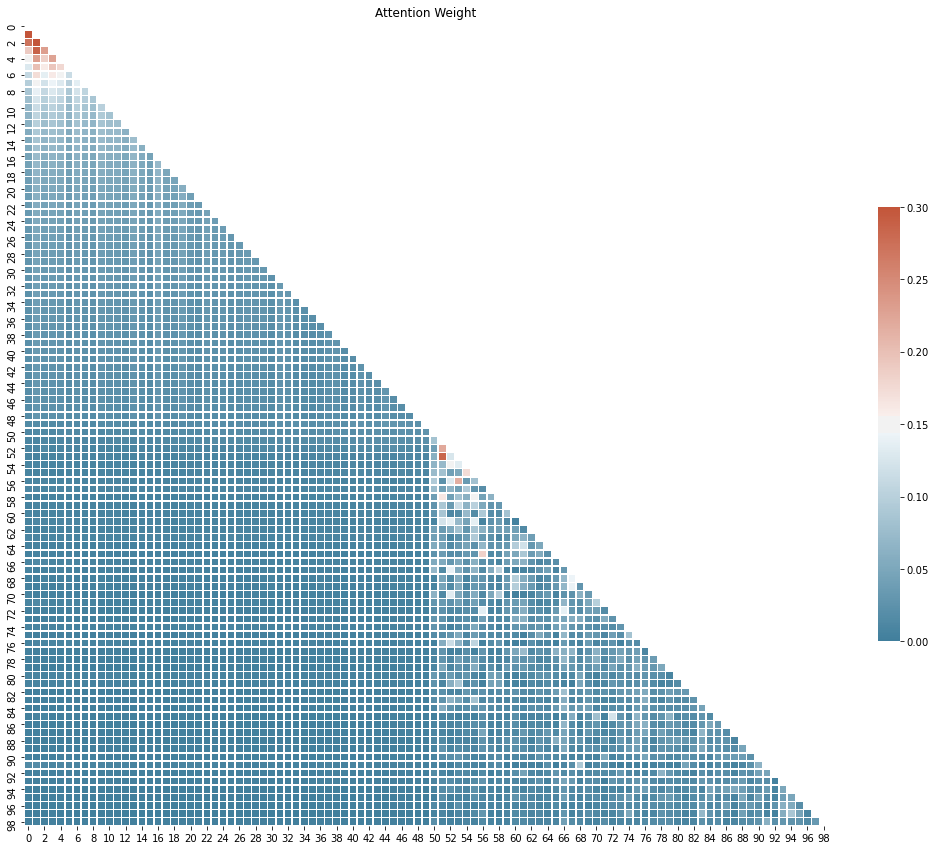

In [28]:
attention_weights = atten_weight[0]

fig, ax = plt.subplots(figsize=(18, 16))
mask = np.triu(np.ones_like(attention_weights, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(attention_weights, mask=mask, cmap=cmap, vmax=.3, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Attention Weight")

plt.show()